In [ ]:
!pip install transformers pyreadstat

# Neural Network V3.0 Roberta-latest with multiclass

This notebook implements a neural network to predict the labels of a tweet (positive, negative ou neutral).

<b>Problem type</b> : <u>multi-class</u>

<b>Neural network used</b> : Transformer with Roberta-tweet-latest for sentiment analysis

<b>Training method</b> : K-fold validation

In [ ]:
%reset -f

## 1. Modules and data imports

In [ ]:
# Libraries imports

import os
import pandas as pd
import tensorflow as tf
import numpy as np
import transformers
import random as rd
import matplotlib.pyplot as plt
import keras.backend as K
import seaborn as sns
import warnings
from numpy.random import seed
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from transformers import AutoTokenizer
from transformers import TFAutoModel
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
warnings.filterwarnings('ignore')

In [ ]:
def set_seed(seed: int = 42) -> None:
    rd.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.experimental.numpy.random.seed(seed)
    # When running on the CuDNN backend, two further options must be set
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_DISABLE_SEGMENT_REDUCTION_OP_DETERMINISM_EXCEPTIONS'] = '1'
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

In [ ]:
set_seed(42)

Random seed set as 42


In [ ]:
# Data import
df = pd.read_spss("/content/drive/MyDrive/VA_EN_TU_2012-2020_3000_tweets_relevant_V03_labeled_1200_cleaned.sav")
# Original labels: 0 - positive, 1 - negative, 2 - neutral
# Remapping dictionary to align with RoBERTa's expected labels
label_mapping = {1: 2, 2: 0, 3: 1}

# Remapped labels: 0 - negative, 1 - neutral, 2 - positive
df['Label_B_emotion'] = df['Label_B_emotion'].replace(label_mapping)
df['Label_B_emotion'] = df['Label_B_emotion'].astype(int)

## Global Constants

In [ ]:
# Constants

nb_samples = len(df) # Number of tweets
proportion_training = 0.80 # 80/20 ratio : 80% of training data for k-fold validation, 20% for test data
pretrained_model_name = "cardiffnlp/twitter-roberta-base-sentiment" # Roberta model for sentiment
seq_len = 131 # tweet length
batch_size = 80
learning_rate = 0.0001
nb_epoch = 60
nb_fold = 3
earlyStopPatience = 10

## 2. Data processing

In [ ]:
def tokenize(sentence):
    tokens = tokenizer.encode_plus(sentence, max_length=seq_len,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_attention_mask=True,
                                   return_token_type_ids=False, return_tensors='tf')
    return tokens['input_ids'], tokens['attention_mask']

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name)

In [ ]:
# Preprocessing all data with Roberta's tokenizer
X_ids = np.zeros((len(df),seq_len))
X_mask = np.zeros((len(df),seq_len))

for i, sentence in enumerate(df['text']):
    X_ids[i, :], X_mask[i, :] = tokenize(sentence)

In [ ]:
sep = round(proportion_training * len(df))
labels = df[['Label_B_emotion']].values.astype('int') # - 1 # to start at 0

# Creating training data
X_ids_train = X_ids[:sep,:]
X_mask_train = X_mask[:sep,:]
Y_train = labels[:sep,:]

# Creating test data
X_ids_test = X_ids[sep:,:]
X_mask_test = X_mask[sep:,:]
Y_test = labels[sep:,:]

## 3. Metrics

In [ ]:
#------------------------STEP 1 --------------------------------#

# Metric1 construction to compute the % of success tweet by tweet

def metric1(y_true, y_pred):
    n = K.cast(K.shape(y_true)[0], 'float32')
    y_pred = K.reshape(y_pred,(n,1))
    res = K.equal(y_true,y_pred)
    res = K.cast(res, 'float32')
    res = K.sum(res) / n
    return res

In [ ]:
#------------------------STEP 2 --------------------------------#

# Metric2 construction to compute the % of success label by label
# (equal to binary-accuracy)

def metric2(y_true, y_pred):
    n = K.cast(K.shape(y_true)[0], 'float32')
    y_pred_r = K.round(y_pred)
    res = abs(y_true - y_pred_r)
    count_error = K.sum(K.cast(K.equal(res, 1), 'float32'),axis=0)
    res = 1-count_error / n
    res = K.mean(res)
    return res

## 4. Model construction

In [ ]:
# Loading pretrained model
pretrained_model = TFAutoModel.from_pretrained(pretrained_model_name)

Some layers from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment were not used when initializing TFRobertaModel: ['classifier']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [ ]:
def get_model():

    input_text_ids = keras.Input(shape=(seq_len,), dtype='int32', name='input_text_ids')
    text_mask = keras.Input(shape=(seq_len,), dtype='int32', name='attention_mask_text')

    embeddings = pretrained_model(input_text_ids, attention_mask=text_mask)[1]

    x = tf.keras.layers.BatchNormalization()(embeddings)
    x = tf.keras.layers.GaussianNoise(0.2)(x)
    x = tf.keras.layers.Dense(512, activation='selu')(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(128, activation='selu')(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(64, activation='selu')(x)
    x = tf.keras.layers.Dropout(0.35)(x)
    x = tf.keras.layers.GaussianNoise(0.2)(x)

    predictions = layers.Dense(3, activation="softmax", name="predictions")(x)

    model = keras.Model(inputs=[input_text_ids,text_mask], outputs=predictions)

    model.layers[2].trainable = False # freeze pretrained model layer

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                loss="sparse_categorical_crossentropy",
                metrics="accuracy")
    return model

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_text_ids (InputLayer  [(None, 131)]                0         []                            
 )                                                                                                
                                                                                                  
 attention_mask_text (Input  [(None, 131)]                0         []                            
 Layer)                                                                                           
                                                                                                  
 tf_roberta_model_16 (TFRob  TFBaseModelOutputWithPooli   1246456   ['input_text_ids[0][0]',      
 ertaModel)                  ngAndCrossAttentions(last_   32         'attention_mask_text[0]

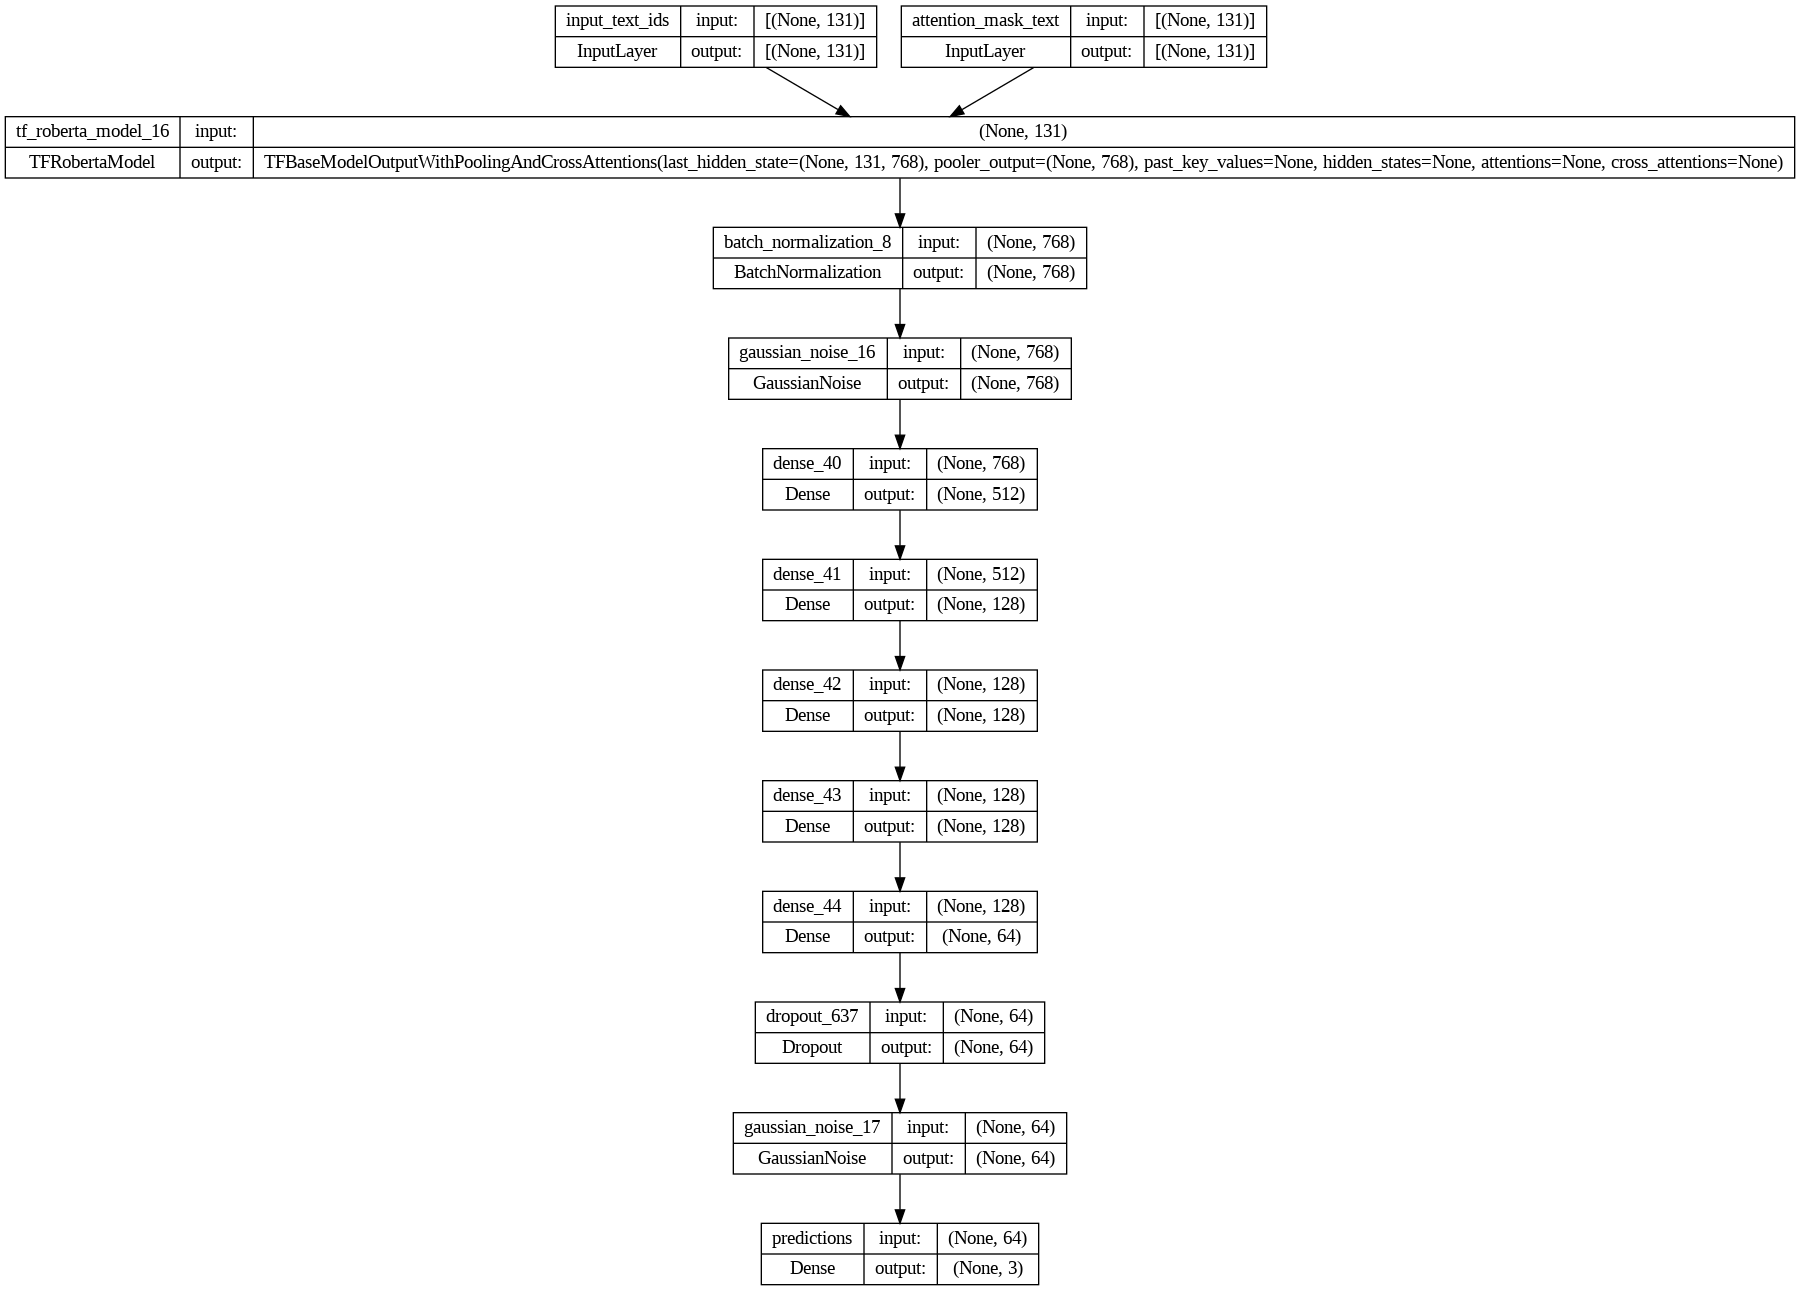

In [ ]:
model = get_model() # model construction
# model visualization
model.summary()
plot_model(model,show_shapes=True)

## 5. Training the model

In [ ]:
def fit_the_model(model, X_tr, y_tr, X_val, y_val, num):
    # The model is trained on data input X_tr, y_tr, having X_val, y_val as validation data
    callbacks = [
        EarlyStopping(monitor="val_accuracy", patience=earlyStopPatience, mode="max"),
        ModelCheckpoint(filepath="MODEL/best_model"+str(num)+".hdf5", monitor="val_accuracy", mode='max', save_best_only=True, verbose=1)
    ]
    model.fit(X_tr, y_tr, validation_data = (X_val,y_val), epochs=nb_epoch, verbose=1, callbacks=callbacks, batch_size=batch_size)
    return model

In [ ]:
list_of_models = [] # To save models
list_history = [] # To save model efficiency

kfold = KFold(n_splits=nb_fold, shuffle=True, random_state=42)

# Training with k-fold method
k = 1
for train_index, val_index in kfold.split(X_ids_train,Y_train):
    print(f'\nTraining model {k}...')
    model = get_model() # Model construction
    history = fit_the_model(model,
                            [X_ids_train[train_index],
                             X_mask_train[train_index]],
                            Y_train[train_index],
                            [X_ids_train[val_index],
                             X_mask_train[val_index]],
                            Y_train[val_index], k) # Model training
    list_of_models.append(history)
    list_history.append(history.history.history)
    k += 1

print("---Finished---")


Training model 1...
Epoch 1/60
8/8 [==============================] - ETA: 0s - loss: 1.2467 - accuracy: 0.4624
Epoch 1: val_accuracy improved from -inf to 0.52978, saving model to MODEL/best_model1.hdf5
8/8 [==============================] - 31s 2s/step - loss: 1.2467 - accuracy: 0.4624 - val_loss: 0.9843 - val_accuracy: 0.5298
Epoch 2/60
8/8 [==============================] - ETA: 0s - loss: 1.1579 - accuracy: 0.5188
Epoch 2: val_accuracy did not improve from 0.52978
8/8 [==============================] - 11s 1s/step - loss: 1.1579 - accuracy: 0.5188 - val_loss: 0.9919 - val_accuracy: 0.5172
Epoch 3/60
8/8 [==============================] - ETA: 0s - loss: 1.0554 - accuracy: 0.5564
Epoch 3: val_accuracy did not improve from 0.52978
8/8 [==============================] - 11s 1s/step - loss: 1.0554 - accuracy: 0.5564 - val_loss: 0.9963 - val_accuracy: 0.5110
Epoch 4/60
8/8 [==============================] - ETA: 0s - loss: 1.0326 - accuracy: 0.5298
Epoch 4: val_accuracy improved from 

## 6. Model performance visualization

In [ ]:
def ConfusionMatrix(y_true , y_pred):
    cm = confusion_matrix(y_true , y_pred)
    return cm/y_true.shape[0]

In [ ]:
# Calculate the proportion of well predicted class for each class

def metric2_per_class(y_true,y_pred):
    L = []
    y_pred = y_pred.reshape((len(y_pred),1))
    for i in range(0,3):
        L.append(y_true[(y_true==y_pred) & (y_true==i)].shape[0] / y_true[(y_true==i)].shape[0])
    return L

-------------------------------------------------- MODEL PERFORMANCE 1 --------------------------------------------------


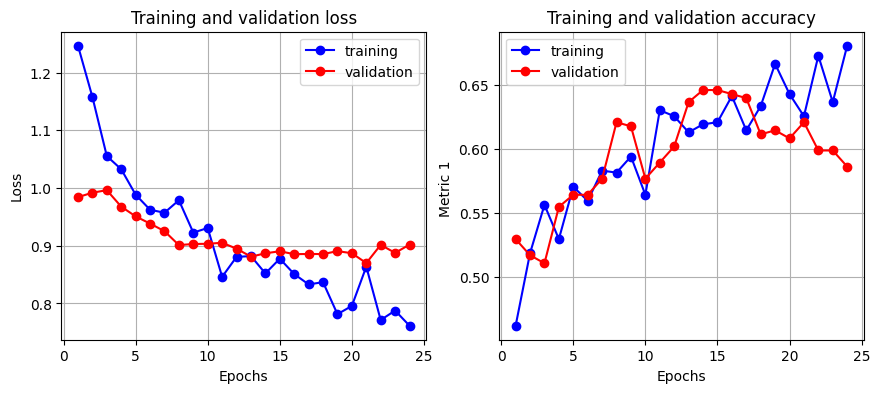

-------------------------------------------------- MODEL PERFORMANCE 2 --------------------------------------------------


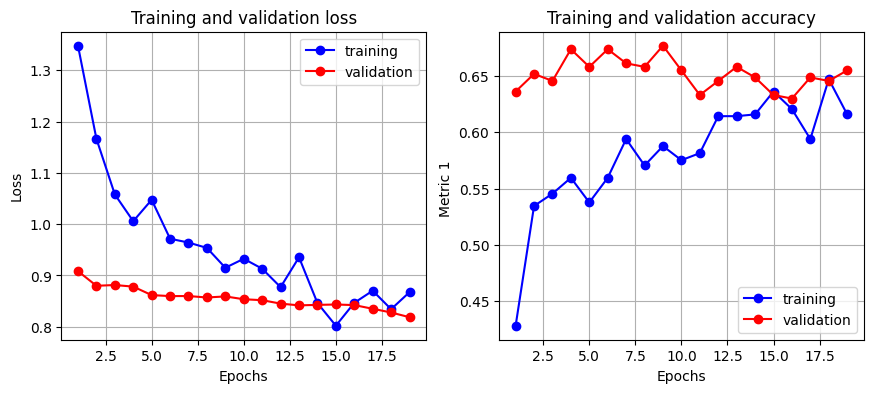

-------------------------------------------------- MODEL PERFORMANCE 3 --------------------------------------------------


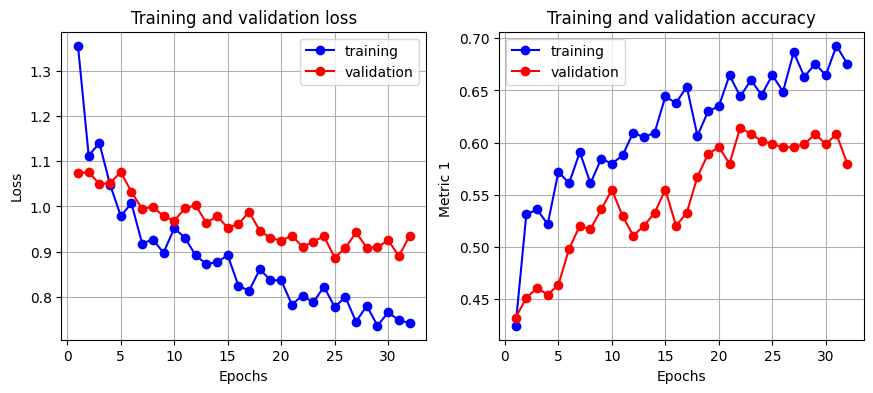

In [ ]:
for i in range(nb_fold):
    print(50*'-',f"MODEL PERFORMANCE {i+1}",50*'-')

    average_loss = list_history[i]['loss']
    average_val_loss = list_history[i]['val_loss']

    average_metric_1 = list_history[i]['accuracy']
    average_val_metric_1 = list_history[i]['val_accuracy']

    plt.figure(figsize=(16,4))

    # Displays model loss and efficiency evolutions for each model
    txtTitres = ["Training and validation loss","Training and validation accuracy"]

    txtYLabel = ["Loss","Metric 1 "]

    L1 = [average_loss, average_metric_1]
    L2 = [average_val_loss, average_val_metric_1]

    for k in range(2):
        if len(L1[0]) < nb_epoch: # to avoid dimension errors when plotting
            nb_epoch_plot=len(L1[0])
        else:
            nb_epoch_plot=nb_epoch
        Epochs = range(1, nb_epoch_plot+1)
        plt.subplot(1,3,k+1)
        plt.plot(Epochs, L1[k], color='b', marker='o', label="training")
        plt.plot(Epochs, L2[k], color='r', marker='o', label="validation")
        plt.grid()
        plt.title(txtTitres[k])
        plt.xlabel("Epochs")
        plt.ylabel(txtYLabel[k])
        plt.legend()
    plt.show()

In [ ]:
# Loading the best model for each fold, our final model will be the "average" of all of them
L_best_models = []
for i in range(nb_fold):
    path = "MODEL/best_model" + str(i+1) + ".hdf5"
    L_best_models.append(keras.models.load_model(path,
                                                 custom_objects={"TFRobertaModel": pretrained_model},
                                                 compile=False))

In [ ]:
# Computing prediction of final model on validation data, accessible via each fold
L_predictions = []
L_cm = []
L_f1 = []
L_m1, L_m2 = [], []

k = 0

# To evaluate our model which prediction will be the median of all predictions, we'll do an
# average of all scores obtained by each model on their own validation_data
kfold = KFold(n_splits=nb_fold, shuffle=True, random_state=42)
for train_index, val_index in kfold.split(X_ids_train,Y_train):

    prediction = np.argmax(L_best_models[k].predict([X_ids_train[val_index], X_mask_train[val_index]]), axis=1) # prediction for this fold's validation data

    cm = ConfusionMatrix(Y_train[val_index] , prediction)
    f1 = f1_score(Y_train[val_index] , prediction, average=None)
    m1 = metric1(Y_train[val_index], prediction)
    m2 = metric2_per_class(Y_train[val_index] , prediction)

    L_predictions.append(prediction)
    L_cm.append(cm)
    L_f1.append(f1)
    L_m1.append(m1)
    L_m2.append(m2)
    k += 1

10/10 [==============================] - 6s 279ms/step


---------------------------------------- SUMMARY OF MODEL PERFORMANCE ON VALIDATION DATA -------------------- 

metric1 validation mean : 0.64576805 

metric2 validation mean per class : [0.65591045 0.56616949 0.72752125] 

Average F1 score on positive/negative/neutral:  [0.64634554 0.61833785 0.66995854]


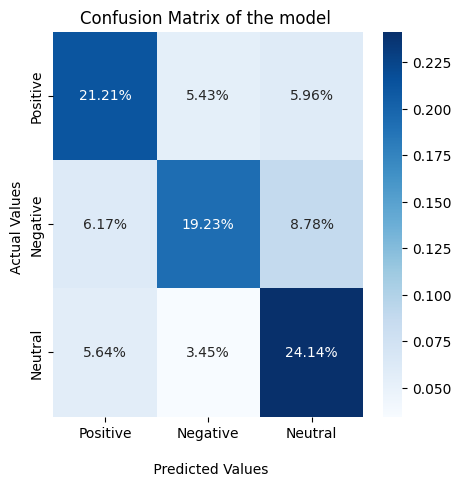

In [ ]:
# Summary of the model's performances on validation data
print(40*'-',f"SUMMARY OF MODEL PERFORMANCE ON VALIDATION DATA",20*'-',"\n")

# Average best metrics
m1 = np.mean(L_m1,axis=0)
m2 = np.mean(L_m2,axis=0)

print("metric1 validation mean :", m1, "\n")
print("metric2 validation mean per class :", m2, "\n")

# Average F1 score
print("Average F1 score on positive/negative/neutral: ", np.mean(L_f1,axis=0))

# Average confusion matrix
avg_cm = np.mean(L_cm,axis=0)
plt.figure(figsize=(5,5))
ax = sns.heatmap(avg_cm, annot=True, fmt='.2%' , cmap="Blues")
ax.set_xlabel('\n Predicted Values')
ax.set_ylabel('Actual Values ')
ax.set_title(f'Confusion Matrix of the model ')
ax.xaxis.set_ticklabels(['Positive', 'Negative' ,'Neutral'])
ax.yaxis.set_ticklabels(['Positive', 'Negative' ,'Neutral'])
plt.show()

# Test

In [ ]:
# Loading pretrained model
pretrained_model = TFAutoModel.from_pretrained(pretrained_model_name)

Some layers from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment were not used when initializing TFRobertaModel: ['classifier']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [ ]:
from sklearn.metrics import multilabel_confusion_matrix

def ConfusionMatrix(y_true , y_pred):
    cm = multilabel_confusion_matrix(y_true , y_pred)
    return cm/y_true.shape[0]

In [ ]:
# Loading the best model for each fold, our final model will be the "average" of all of them
L_best_models = []
for i in range(nb_fold):
    path = "MODEL/best_model" + str(i+1) + ".hdf5"
    L_best_models.append(keras.models.load_model(path,
                                                 custom_objects={"TFRobertaModel": pretrained_model,
                                                                 "metric1": metric1,
                                                                 "metric2":metric2},
                                                 compile=False))

In [ ]:
L_pred = [np.round(model.predict([X_ids_test, X_mask_test])) for model in L_best_models]
prediction = np.median(L_pred, axis=0)

predicted_labels = np.argmax(prediction, axis=1).reshape(-1, 1)

8/8 [==============================] - 6s 270ms/step


In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score, f1_score


print("Classification Report: \n", classification_report(Y_test, predicted_labels,target_names=['Negative','Neutral','Positive']))

Classification Report: 
               precision    recall  f1-score   support

    Negative       0.50      0.86      0.63        90
     Neutral       0.75      0.25      0.38        84
    Positive       0.59      0.51      0.55        65

    accuracy                           0.55       239
   macro avg       0.61      0.54      0.52       239
weighted avg       0.61      0.55      0.52       239



In [ ]:
# Computing prediction of final model on test data

L_pred = [np.round(model.predict([X_ids_test, X_mask_test])) for model in L_best_models]
prediction = np.median(L_pred, axis=0) # prediction of final model on test data, that's where nb_fold needs to be odd

predicted_labels = np.argmax(prediction, axis=1).reshape(-1, 1)

cm = ConfusionMatrix(Y_test , predicted_labels)
f1 = f1_score(Y_test , predicted_labels, average=None)
m1 = float(metric1(Y_test, predicted_labels))
m2 = float(metric2(Y_test, predicted_labels))
diff = np.abs(predicted_labels-Y_test)
m3 = metric2_per_labels(diff)

8/8 [==============================] - 2s 277ms/step


In [ ]:
metric2(Y_test, predicted_labels)

<tf.Tensor: shape=(), dtype=float32, numpy=0.70711297>

In [ ]:
# Summary of the model's performances on testing data
print(40*'-',f"SUMMARY OF MODEL PERFORMANCE ON TEST DATA",20*'-',"\n")

# metrics
print("metric1 test mean :", m1, "\n")
print("metric2 test mean :", m2, "\n")
print("metric2 test mean per labels :", m3, "\n")

# F1 score
print("F1 score on positive/negative/neutral: ", f1)

# Confusion matrix
L_titles = ['Confusion Matrix for Positive label', 'Confusion Matrix for Negative label', 'Confusion Matrix for Neutral label']
L_labels = ['Not Positive', 'Positive', 'Not Negative', 'Negative', 'Not Neutral', 'Neutral']

k = 0
for i in range(3):
    plt.figure(figsize=(3,3))
    ax = sns.heatmap(cm[i], annot=True, fmt='.2%' , cmap="Blues")
    ax.set_xlabel('\n Predicted Values')
    ax.set_ylabel('Actual Values ')
    ax.set_title(L_titles[i])
    ax.xaxis.set_ticklabels(L_labels[k:k+2])
    ax.yaxis.set_ticklabels(L_labels[k:k+2])
    k += 2
    plt.show()

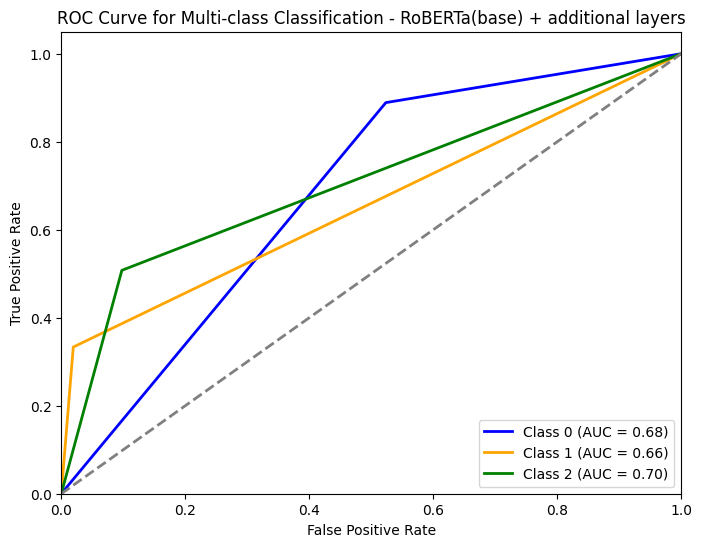

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Convert true labels and predictions to one-hot encoded format
one_hot_true_labels = label_binarize(Y_test, classes=[0, 1, 2])
one_hot_predictions = label_binarize(predicted_labels, classes=[0, 1, 2])

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):  # having 3 classes
    fpr[i], tpr[i], _ = roc_curve(one_hot_true_labels[:, i], one_hot_predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
colors = ['blue', 'orange', 'green']
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-class Classification - RoBERTa(base) + additional layers')
plt.legend(loc="lower right")
plt.show()
